## Examine the effect of going to Catholic school vs Public school.
#### Data from 'Early Childhood Longitudinal Study' is downloaded from https://www.researchconnections.org/childcare/studies/4075?q=c5r2mtsc&type=Data+Sets
Data preprocessing work is based on the work of sejdemyr 'https://github.com/sejdemyr/ecls'.

In [147]:
import sys
sys.path.append('/analytics/shared/packages/')

In [148]:
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
import statsmodels.discrete.discrete_model as sm
from statsmodels.formula import api
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [149]:
import numpy as np

In [150]:
df = pd.read_csv('data/ecls.csv', encoding='UTF-8')
df.sample(5)

,childid,catholic,race,race_white,race_black,race_hispanic,race_asian,p5numpla,p5hmage,p5hdage,...,w3daded_hsb,w3momed_hsb,w3momscr,w3dadscr,w3inccat,w3income,w3povrty,p5fstamp,c5r2mtsc,c5r2mtsc_std
4800,0606009C,0,"BLACK OR AFRICAN AMERICAN, NON-HISPANIC",0,1,0,0,1.0,41.0,47.0,...,0.0,1.0,38.18,33.42,"$200,001 TO $200,001",200001.0,0.0,0.0,44.839,-0.583397
8454,1078009C,0,"HISPANIC, RACE NOT SPECIFIED",0,0,1,0,2.0,29.0,34.0,...,1.0,1.0,NaN,39.20,"$35,001 TO $40,000",37500.5,0.0,0.0,36.430,-1.449048
7648,0947019C,0,"HISPANIC, RACE NOT SPECIFIED",0,0,1,0,1.0,39.0,44.0,...,0.0,1.0,34.95,34.95,"$10,001 TO $15,000",12500.5,1.0,1.0,57.786,0.749410
2281,0306001C,1,"WHITE, NON-HISPANIC",1,0,0,0,1.0,40.0,42.0,...,0.0,0.0,NaN,48.69,"$40,001 TO $50,000",45000.5,0.0,0.0,55.158,0.478875
7225,0882018C,0,"WHITE, NON-HISPANIC",1,0,0,0,2.0,NaN,38.0,...,0.0,NaN,NaN,52.54,"$30,001 TO $35,000",32500.5,0.0,0.0,49.383,-0.115623


## 1.Pre-Analysis using non-matched data
### 1.1 Difference in means: outcome variables

Looking at students standaridized match score (c5r2mtsc_std) of students from catholic ( catholic = 1) and public (catholic = 0) schools.

In [151]:
df[['childid', 'catholic', 'c5r2mtsc_std']].groupby(['catholic']).agg(['count','mean',stats.sem])

c5r2mtsc_std                    
                count      mean       sem
catholic                                 
0                9568 -0.030596  0.010385
1                1510  0.193868  0.022353

Since math score is standarized, we can conclude that the catholic students average math score is more than 20% of a standard deviation higher than that of public students.

In [152]:
stats.ttest_ind(df[df.catholic == 1]['c5r2mtsc_std'],df[df.catholic == 0]['c5r2mtsc_std'] )

Ttest_indResult(statistic=8.129941988954517, pvalue=4.752225684279406e-16)

Also from the ttest, we can see that the difference in average math score is statistiaclly significant. 

### 1.2 Difference in means: pre-treatment covariates

Covariates: <br>
    race_white: 1=yes, 0=No <br>
    p5hmage: mothers age <br>
    w3income: family income <br>
    p5numpla: number of places student has lived for at least 4 months <br>
    w3momed_hsb: is mothers education highschool or below(1), or college degree/more (0)

### Mean for each covariates

In [153]:
(df[['catholic', 'race_white', 'p5hmage','w3income','p5numpla','w3momed_hsb']]
 .groupby(['catholic']).agg(['mean']))

,race_white,p5hmage,w3income,p5numpla,w3momed_hsb
,mean,mean,mean,mean,mean
catholic,,,,,
0,0.556125,37.560970,54889.159064,1.132669,0.464092
1,0.725166,39.575163,82074.300501,1.092701,0.227207


In [154]:
for x in ['race_white', 'p5hmage','w3income','p5numpla','w3momed_hsb']:
    print("Variable: " + x)
    print(stats.ttest_ind(df[df.catholic == 1][x].dropna(),df[df.catholic == 0][x].dropna()))


Variable: race_white
Ttest_indResult(statistic=12.450367999574826, pvalue=2.398953024611241e-35)
Variable: p5hmage
Ttest_indResult(statistic=10.793536203115156, pvalue=5.302915317001201e-27)
Variable: w3income
Ttest_indResult(statistic=21.29597069456485, pvalue=2.161494782851299e-98)
Variable: p5numpla
Ttest_indResult(statistic=-3.5239085421140763, pvalue=0.0004272306475610962)
Variable: w3momed_hsb
Ttest_indResult(statistic=-16.68066304714088, pvalue=1.3607115748238347e-61)


From the p-value, we can see that all mean differences are statistically significant.

## 2 Propensity Score Matching

In [155]:
students = df[['catholic','race_white','w3income','p5hmage', 'p5numpla','w3momed_hsb','c5r2mtsc_std']].dropna().copy()
students['w3income_1k'] = students['w3income'].apply(lambda x: x/1000)
students = students.drop('w3income', axis=1)
students = students.reset_index().drop('index', axis=1)
students.sample(5)

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,c5r2mtsc_std,w3income_1k
6199,0,0,32.0,1.0,1.0,-2.006383,17.5005
1795,1,1,42.0,1.0,0.0,-0.138373,150.0005
8106,0,0,33.0,1.0,1.0,-0.315745,87.5005
7287,0,0,37.0,1.0,0.0,-1.668317,32.5005
607,0,1,34.0,2.0,1.0,-0.804108,62.5005


In [156]:
students.dtypes

catholic          int64
race_white        int64
p5hmage         float64
p5numpla        float64
w3momed_hsb     float64
c5r2mtsc_std    float64
w3income_1k     float64
dtype: object

In [157]:
lor = LogisticRegression()
propensity = lor.fit(students.loc[:, (students.columns != 'catholic') & (students.columns != 'c5r2mtsc_std')], students.catholic)
pscore = propensity.predict_proba(students.loc[:, (students.columns != 'catholic') & (students.columns != 'c5r2mtsc_std')])[:,1]
# probability is ordered on class lebel

# score from Logistic Regression
students['prop_score'] = pscore

In [158]:
students.head(5)

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,c5r2mtsc_std,w3income_1k,prop_score
0,0,1,47.0,1.0,0.0,0.981753,62.5005,0.226005
1,0,1,41.0,1.0,0.0,0.594378,45.0005,0.180133
2,0,1,43.0,1.0,0.0,0.490611,62.5005,0.208226
3,1,1,38.0,1.0,0.0,1.451278,87.5005,0.216810
4,0,1,47.0,1.0,0.0,2.595699,150.0005,0.355799


In [159]:
lor.intercept_

array([-3.04773578])

In [160]:
lor.coef_

array([[ 0.3043212 ,  0.02616123, -0.17243479, -0.70163013,  0.00728416]])

In [161]:
y, X = dmatrices('catholic ~ C(race_white) + p5hmage + p5numpla + w3momed_hsb + w3income_1k', 
                 students, return_type = 'dataframe')

In [162]:
logit = sm.Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.386794
         Iterations 7


In [163]:
logit.params

Intercept            -3.212552
C(race_white)[T.1]    0.314501
p5hmage               0.029217
p5numpla             -0.143939
w3momed_hsb          -0.693587
w3income_1k           0.007304
dtype: float64

In [164]:
# Adding score from logit model as well
# Logistic regression has L2 regularization by default. So the ps score from LR and Logit might not match
students['logit_score'] = logit.predict(X)

In [165]:
students.sample(5)

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,c5r2mtsc_std,w3income_1k,prop_score,logit_score
2730,1,1,38.0,1.0,1.0,0.383447,62.5005,0.102653,0.102583
2403,0,0,36.0,1.0,1.0,1.648414,45.0005,0.065853,0.064791
7028,0,0,42.0,1.0,0.0,2.140381,62.5005,0.158940,0.158039
2582,0,0,76.0,1.0,1.0,0.608790,12.5005,0.136757,0.149529
1716,0,0,29.0,1.0,1.0,0.952620,87.5005,0.074072,0.071511


Notice the prop_score from Logistic Regression and logit_score from Logit function. They do not match exactly and are pretty close.

Text(0.5,0.98,'Probability of going to Catholic School')

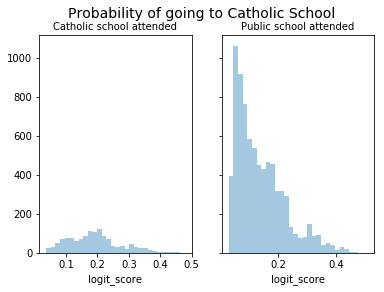

In [166]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
sns.distplot(students[students.catholic == 1]['logit_score'], bins= 30, kde=False, hist=True, ax= ax1)
sns.distplot(students[students.catholic == 0]['logit_score'], bins= 30, kde=False, hist=True, ax= ax2)
ax1.set_title("Catholic school attended", fontsize=10)
ax2.set_title("Public school attended", fontsize=10)
fig.suptitle("Probability of going to Catholic School", fontsize=14)

## 3 Matching Algorithm

In [167]:
np.random.seed(10)

def Match(groups, pscore, caliper=0.05):
    '''
    Inputs: 
    groups = indicator to identify control and study group. Must be two groups. Number of treated (study) records should be
            smaller than untreated (control) records.
    pscore = propensity scores for each observation. Groups and pscore must be in the same order ( same indices).
    caliper = maximum difference in matched propensity scores.
    
    Outputs:
    returns a dataframe with four columns
    std_indx: index of the study record
    std_pscore: propensity score of the study record used for matching
    ctl_indx: index of control record that matches with the study record
    ctl_pscore: propensity score of the control record used for matching
    
    '''
    if any(pscore <= 0) or any(pscore >= 1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0<caliper<1):
        raise ValueError('Caliper must be between 0 and 1')
    elif len(groups) != len(pscore):
        raise ValueError('groups and pscore must have same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups')
     
    
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups.sum(); 
    N2 = N - N1;
    g1, g2 = (pscore[groups == 1]),(pscore[groups == 0])
    # N1 is study, N2 is control
    # assuming number of study groups is less than control groups
    if N1 > N2:
        N1, N2, g1, g2 = N2, N1, g2, g1

    if (N1 != len(g1)) or (N2 != len(g2)):
        raise ValueError('Number of study records must be less than control records')

    morder = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.NAN

    for m in morder:
        dist = abs(g1.iloc[m] - g2)
        if dist.min() <= caliper:
            matches[m] = dist.idxmin()
            g2 = g2.drop(matches[m])
            
    study = pd.DataFrame(g1).reset_index()
    study.columns = ['std_indx', 'std_pscore']
    control = pd.DataFrame(students.iloc[matches]['logit_score']).reset_index()
    control.columns = ['ctl_indx', 'ctl_pscore']
    
    final_df = study.join(control)

    return final_df
        

In [168]:
matches = Match(students.catholic, students.logit_score, 0.05)

In [169]:
matches.head()

,std_indx,std_pscore,ctl_indx,ctl_pscore
0,3,0.215402,2257,0.215402
1,33,0.169386,2042,0.169386
2,34,0.290602,5285,0.290160
3,35,0.200958,2934,0.200958
4,36,0.321143,2456,0.321143


In [170]:
study = students.iloc[matches.std_indx]
control = students.iloc[matches.ctl_indx]
final = study.append(control)


In [171]:
study.head(5)

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,c5r2mtsc_std,w3income_1k,prop_score,logit_score
3,1,1,38.0,1.0,0.0,1.451278,87.5005,0.216810,0.215402
33,1,1,39.0,2.0,0.0,0.157383,62.5005,0.166210,0.169386
34,1,1,41.0,2.0,0.0,1.485352,150.0005,0.284338,0.290602
35,1,1,35.0,1.0,0.0,-0.501969,87.5005,0.203779,0.200958
36,1,1,41.0,1.0,0.0,-0.204360,150.0005,0.320688,0.321143


In [172]:
control.head(5)

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,c5r2mtsc_std,w3income_1k,prop_score,logit_score
2257,0,1,38.0,1.0,0.0,0.238914,87.5005,0.216810,0.215402
2042,0,1,39.0,2.0,0.0,0.483302,62.5005,0.166210,0.169386
5285,0,1,36.0,1.0,0.0,0.529523,150.0005,0.292884,0.290160
2934,0,1,35.0,1.0,0.0,0.860898,87.5005,0.203779,0.200958
2456,0,1,41.0,1.0,0.0,0.678585,150.0005,0.320688,0.321143


If we have done matching properly, each covariates mean should match for study and control group.

### Covariates mean

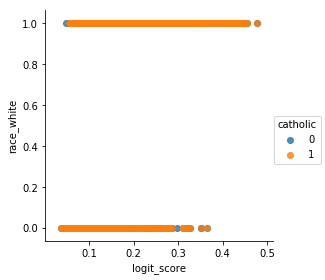

In [173]:
sns.lmplot(x='logit_score', y='race_white', hue='catholic',
           data = final, size = 4, fit_reg = False)


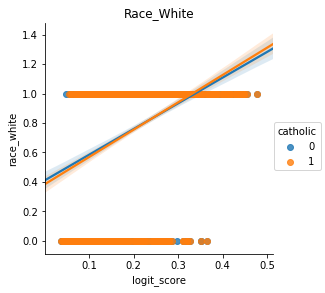

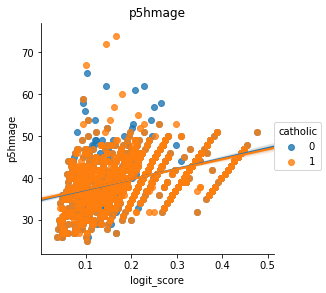

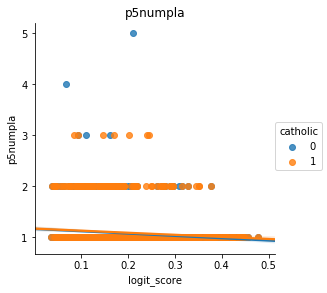

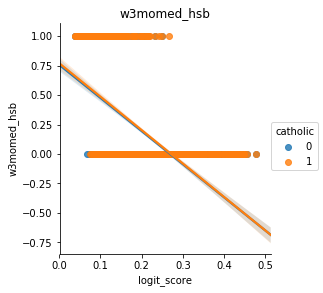

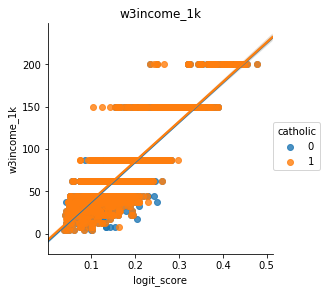

In [174]:

sns.lmplot(x='logit_score', y='race_white', hue='catholic',
           data = final, size = 4, fit_reg = True)
ax1 = plt.gca()
ax1.set_title("Race_White")

sns.lmplot(x='logit_score', y='p5hmage', hue='catholic',
           data = final, size = 4, fit_reg = True)
ax2 = plt.gca()
ax2.set_title("p5hmage")

sns.lmplot(x='logit_score', y='p5numpla', hue='catholic',
           data = final, size = 4, fit_reg = True)
ax3 = plt.gca()
ax3.set_title("p5numpla")

sns.lmplot(x='logit_score', y='w3momed_hsb', hue='catholic',
           data = final, size = 4, fit_reg = True)
ax4 = plt.gca()
ax4.set_title("w3momed_hsb")

sns.lmplot(x='logit_score', y='w3income_1k', hue='catholic',
           data = final, size = 4, fit_reg = True)
ax5 = plt.gca()
_=ax5.set_title("w3income_1k")


### After matching, we can see that when we plot a regression line, it is same for both catholic and public students. However if we plot similar graphs before matching, we can see the different in the regression line. This also confirms we have removed sample imbalance with matching.

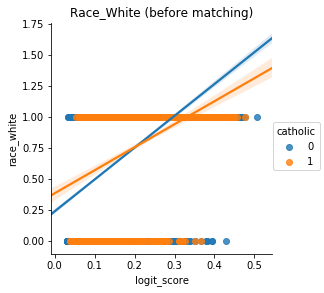

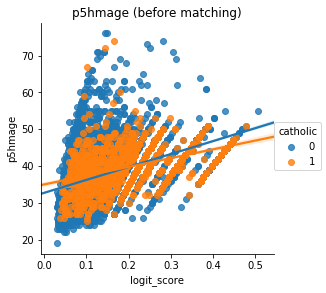

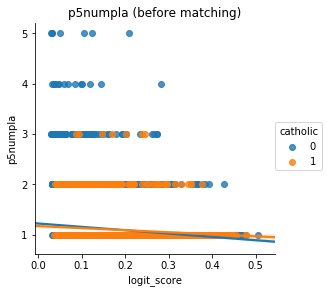

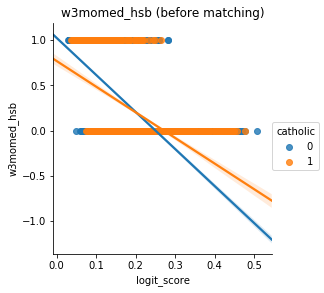

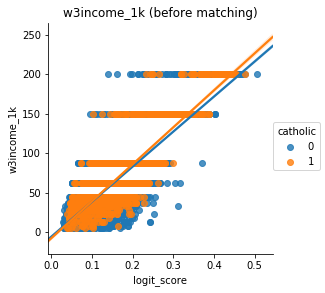

In [175]:
sns.lmplot(x='logit_score', y='race_white', hue='catholic',
           data = students, size = 4, fit_reg = True)
ax1 = plt.gca()
ax1.set_title("Race_White (before matching)")

sns.lmplot(x='logit_score', y='p5hmage', hue='catholic',
           data = students, size = 4, fit_reg = True)
ax2 = plt.gca()
ax2.set_title("p5hmage (before matching)")

sns.lmplot(x='logit_score', y='p5numpla', hue='catholic',
           data = students, size = 4, fit_reg = True)
ax3 = plt.gca()
ax3.set_title("p5numpla (before matching)")

sns.lmplot(x='logit_score', y='w3momed_hsb', hue='catholic',
           data = students, size = 4, fit_reg = True)
ax4 = plt.gca()
ax4.set_title("w3momed_hsb (before matching)")

sns.lmplot(x='logit_score', y='w3income_1k', hue='catholic',
           data = students, size = 4, fit_reg = True)
ax5 = plt.gca()
_=ax5.set_title("w3income_1k (before matching)")

## After matching analysis

### Mean for each covariates

In [176]:
(final[['catholic', 'race_white', 'p5hmage','w3income_1k','p5numpla','w3momed_hsb']]
 .groupby(['catholic']).agg(['mean', 'sem']))

race_white              p5hmage           w3income_1k            \
               mean       sem       mean       sem        mean       sem   
catholic                                                                   
0          0.746302  0.011838  39.559172  0.142394   81.403993  1.267849   
1          0.741124  0.011917  39.593195  0.142334   82.568936  1.275036   

          p5numpla           w3momed_hsb            
              mean       sem        mean       sem  
catholic                                            
0         1.076183  0.008077    0.215237  0.011181  
1         1.091716  0.008326    0.223373  0.011332

Mean for each covariates is very close. I do not expect the mean difference to be statistically significant. Lets confirm 
with the ttest.

In [177]:
for x in ['race_white', 'p5hmage','w3income_1k','p5numpla','w3momed_hsb']:
    print("Variable: " + x)
    print(stats.ttest_ind(final[final.catholic == 1][x].dropna(),final[final.catholic == 0][x].dropna()))

Variable: race_white
Ttest_indResult(statistic=-0.30823055964253404, pvalue=0.7579306598519536)
Variable: p5hmage
Ttest_indResult(statistic=0.1689916912533004, pvalue=0.8658158261435221)
Variable: w3income_1k
Ttest_indResult(statistic=0.6478749845988445, pvalue=0.5171208568396295)
Variable: p5numpla
Ttest_indResult(statistic=1.3390138402460645, pvalue=0.1806788006930459)
Variable: w3momed_hsb
Ttest_indResult(statistic=0.5110752908010489, pvalue=0.6093400932378217)


With such large values and the significance level of 0.05, we do not have enough statistical evidence to reject null hypothesis.
So we will conclude that there is no difference in these covariates in kids who went to catholic school vs kids who went to public school.( Another confirmatation that we have matched properly.) 

### Treatment effect

Now lets look at students standaridized match score (c5r2mtsc_std) from catholic and public.

In [178]:
from sklearn.linear_model import LinearRegression

In [179]:

df = df.reset_index()
df = df.set_index('index')
final = final.reset_index()
final = final.set_index('index')

In [181]:
final.head()

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,c5r2mtsc_std,w3income_1k,prop_score,logit_score
index,,,,,,,,,
3,1,1,38.0,1.0,0.0,1.451278,87.5005,0.216810,0.215402
33,1,1,39.0,2.0,0.0,0.157383,62.5005,0.166210,0.169386
34,1,1,41.0,2.0,0.0,1.485352,150.0005,0.284338,0.290602
35,1,1,35.0,1.0,0.0,-0.501969,87.5005,0.203779,0.200958
36,1,1,41.0,1.0,0.0,-0.204360,150.0005,0.320688,0.321143


### Using only catholic variable

In [184]:
lr = LinearRegression().fit(final[['catholic']], final.c5r2mtsc_std)
lr.score(final[['catholic']], final.c5r2mtsc_std)

0.006637661737108891

In [185]:
ols = api.ols('c5r2mtsc_std ~ C(catholic)', data = final).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           c5r2mtsc_std   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     18.05
Date:                Fri, 06 Apr 2018   Prob (F-statistic):           2.22e-05
Time:                        16:08:50   Log-Likelihood:                -3588.8
No. Observations:                2704   AIC:                             7182.
Df Residuals:                    2702   BIC:                             7193.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3588      0.025     14.456      0.000       0.310       0.407
C(catholic)[T.1]    -0.1492      0.035     -4.249      0.000      -0.218      -0.080
==============================================================================
Omnibus:                       29.038   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.731
Skew:                          -0.248   Prob(JB):                     3.50e-07
Kurtosis:                       3.134   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Conclusion: Since the R-squared is negligiblle we will conclude that changes in standarized math score can not be reduced from just catholic variable.

### Using other covariates as well

In [186]:
lr = LinearRegression().fit(final[['catholic', 'race_white', 'p5hmage','w3income_1k','p5numpla','w3momed_hsb']], 
                            final.c5r2mtsc_std)
lr.score(final[['catholic', 'race_white', 'p5hmage','w3income_1k','p5numpla','w3momed_hsb']], final.c5r2mtsc_std)

0.1168335281545424

In [187]:
ols = api.ols('c5r2mtsc_std ~ C(catholic)+C(race_white)+p5hmage+w3income_1k+p5numpla+w3momed_hsb', data = final).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           c5r2mtsc_std   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     59.46
Date:                Fri, 06 Apr 2018   Prob (F-statistic):           2.18e-69
Time:                        16:08:57   Log-Likelihood:                -3429.8
No. Observations:                2704   AIC:                             6874.
Df Residuals:                    2697   BIC:                             6915.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4789      0.148     -3.232      0.001      -0.769      -0.188
C(catholic)[T.1]      -0.1481      0.033     -4.468      0.000      -0.213      -0.083
C(race_white)[T.1]     0.3107      0.039      8.060      0.000       0.235       0.386
p5hmage                0.0118      0.003      3.661      0.000       0.005       0.018
w3income_1k            0.0032      0.000      8.498      0.000       0.002       0.004
p5numpla              -0.0409      0.055     -0.740      0.459      -0.149       0.067
w3momed_hsb           -0.3578      0.041     -8.664      0.000      -0.439      -0.277
==============================================================================
Omnibus:                       24.346   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.889
Skew:                          -0.221   Prob(JB):                     3.94e-06
Kurtosis:                       3.158   Cond. No.                         919.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Conclusion: Even adding few covariaties we have a very low R-squread. So we will conclude these covariates can not explain the changes in the standaried math score.

In [190]:
final[['catholic', 'c5r2mtsc_std']].groupby(['catholic']).agg(['count','mean','sem'])

c5r2mtsc_std                    
                count      mean       sem
catholic                                 
0                1352  0.358825  0.026009
1                1352  0.209668  0.023575

### Notive the mean here. Before matching we saw that the average math score for catholic students was higher than public students but after matching we are seeing that the average math score for public students is higher than catholic students.

### (The story can be different when we add more covariates on regression and also for matching purposes, however we will conclude what we have seen from above analysis.) 
1. Average math score of students attending public school is higher than that of students attending catholic school.
2. We do not see enough evidence that the changes in math score can be reduced from covariates we were using.